In [25]:
import sxsc_tushare as sx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import *
from numpy.linalg import multi_dot
sx.set_token("0a3191104cd108eccc6d1d4ce8a431f8d99fb786926e5d788f3b55c5")#因为这个账号是私有的 所以老师我无法把真实通行token给到你
pro = sx.get_api(env="prd")

In [27]:
df = pro.daily( ts_code = ' 600298.SH, 600872.SH, 600186.SH', start_date='20041231', end_date='20241231', )
df.head(10)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600872.SH,20241231,22.90,22.95,21.97,22.02,22.88,-0.86,-3.7587,128218.61,286369.862
1,600298.SH,20241231,36.26,36.57,36.05,36.05,36.26,-0.21,-0.5792,46909.80,170140.988
2,600186.SH,20241231,5.02,5.70,4.92,5.70,5.18,0.52,10.0386,2546273.82,1386903.837
3,600186.SH,20241230,5.39,5.39,5.11,5.18,4.90,0.28,5.7143,1863664.92,980407.231
4,600298.SH,20241230,36.32,36.71,36.10,36.26,36.37,-0.11,-0.3024,41062.20,149470.040
5,600872.SH,20241230,23.27,23.36,22.75,22.88,23.26,-0.38,-1.6337,113979.32,261826.508
6,600872.SH,20241227,23.31,23.43,22.98,23.26,23.27,-0.01,-0.0430,87356.00,202761.922
7,600298.SH,20241227,35.90,36.55,35.83,36.37,35.97,0.40,1.1120,43404.66,157068.130
8,600186.SH,20241227,4.83,5.01,4.75,4.90,4.78,0.12,2.5105,529206.00,259854.243
9,600186.SH,20241226,4.70,4.84,4.67,4.78,4.74,0.04,0.8439,366488.89,175079.632


In [28]:
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
# df = df.sort_values('trade_date' )ascending = True
df = df.sort_values('trade_date', ascending=True)

In [29]:
df_filtered = df[['ts_code', 'trade_date', 'close']]

In [33]:
df_filtered

,ts_code,trade_date,close
5999,600186.SH,2016-10-11,5.50
5996,600298.SH,2016-10-12,16.92
5998,600186.SH,2016-10-12,5.46
5997,600872.SH,2016-10-12,14.99
5993,600186.SH,2016-10-13,5.53
...,...,...,...
4,600298.SH,2024-12-30,36.26
3,600186.SH,2024-12-30,5.18
2,600186.SH,2024-12-31,5.70
1,600298.SH,2024-12-31,36.05


In [35]:
df_pivot = df_filtered.pivot(
    index='trade_date',   # 行索引为日期
    columns='ts_code',    # 列索引为股票代码
    values='close'        # 填充值为收盘价
)



In [37]:
df_pivot 

ts_code,600186.SH,600298.SH,600872.SH
trade_date,,,
2016-10-11,5.50,NaN,NaN
2016-10-12,5.46,16.92,14.99
2016-10-13,5.53,17.05,14.98
2016-10-14,5.52,16.96,15.69
2016-10-17,5.41,17.30,15.44
...,...,...,...
2024-12-25,4.74,35.44,23.12
2024-12-26,4.78,35.97,23.27
2024-12-27,4.90,36.37,23.26


In [39]:
df_filled = df_pivot.fillna(method='bfill', axis=0)
df_filled


C:\Users\perco\AppData\Local\Temp\ipykernel_17752\3706142441.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_pivot.fillna(method='bfill', axis=0)


ts_code,600186.SH,600298.SH,600872.SH
trade_date,,,
2016-10-11,5.50,16.92,14.99
2016-10-12,5.46,16.92,14.99
2016-10-13,5.53,17.05,14.98
2016-10-14,5.52,16.96,15.69
2016-10-17,5.41,17.30,15.44
...,...,...,...
2024-12-25,4.74,35.44,23.12
2024-12-26,4.78,35.97,23.27
2024-12-27,4.90,36.37,23.26


In [59]:
returns = np.log(df_filled/df_filled.shift(1)).dropna()

returns.shape

(2001, 3)

In [65]:
# 组合的股票构成

symbols = ['600186.SH','600298.SH','600872.SH']
numofasset = len(symbols)
 
# 定义一个组合的函数
def portfolio_simulation(returns):
    rets = []; vols=[]; wts=[]
    
    # 模拟10000次3只股票不同权重的组合
    for i in tqdm(range(10000)):
        # 产生随机权重
        weights = np.random.random(numofasset)[:, np.newaxis]
        weights = weights/weights.sum()
        
        # 记录组合的收益、波动、权重
        rets.append(weights.T @ np.array(returns.mean()*250)[:,np.newaxis])
        vols.append(np.sqrt(multi_dot([weights.T, returns.cov()*250, weights])))
        wts.append(weights.flatten())
        
    # 记录组合各数据
    portdf =  pd.DataFrame({
        'port_rets': np.array(rets).flatten(),
        'port_vols': np.array(vols).flatten(),
        'weights': list(np.array(wts))
        })
    portdf['Sharp_ratio']=(portdf['port_rets']-0.02)/(portdf['port_vols'])  #假设rf为0
    
    return round(portdf, 2)

temp = portfolio_simulation(returns)
temp.head(10)

100%|██████████| 10000/10000 [00:12<00:00, 803.83it/s]


,port_rets,port_vols,weights,Sharp_ratio
0,0.04,0.30,"[0.41179385297477283, 0.17184833082404277, 0.4...",0.06
1,0.06,0.29,"[0.30299938610245236, 0.546479552749917, 0.150...",0.14
2,0.05,0.28,"[0.3717171788265156, 0.3946572169930487, 0.233...",0.11
3,0.06,0.29,"[0.1937271598842415, 0.4893843667078411, 0.316...",0.15
4,0.03,0.31,"[0.4635263064052699, 0.07684241047789951, 0.45...",0.04
5,0.05,0.31,"[0.19356807321129144, 0.19955948815361674, 0.6...",0.09
6,0.05,0.28,"[0.3384910185480077, 0.43963556444614016, 0.22...",0.12
7,0.04,0.30,"[0.2952264024356589, 0.1641078766031486, 0.540...",0.08
8,0.06,0.29,"[0.34162208275694406, 0.5220031841296862, 0.13...",0.13
9,0.05,0.28,"[0.33354211441841813, 0.35135959344188045, 0.3...",0.11


In [67]:
temp.iloc[temp.Sharp_ratio.idxmax()]

port_rets                                                   0.09
port_vols                                                   0.35
weights        [0.013540569788179921, 0.9737957229698365, 0.0...
Sharp_ratio                                                 0.21
Name: 3604, dtype: object

D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33945 (\N{CJK UNIFIED IDEOGRAPH-8499}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site

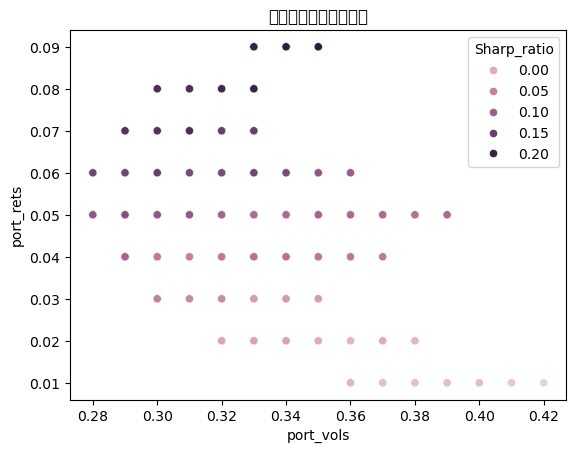

In [87]:
import seaborn as sns
sns.scatterplot(data=temp, x='port_vols', y='port_rets', hue='Sharp_ratio')
plt.title('投资组合蒙特卡洛模拟')
plt.show()




In [103]:
# weights( 0.013,0.973,0.014) 归一化最优夏普
weights_dict = {'600186.SH': 0.013, '600298.SH': 0.973, '600872.SH': 0.014}
result = df_filled[weights_dict.keys()].dot(pd.Series(weights_dict))
result

trade_date
2016-10-11    16.74452
2016-10-12    16.74400
2016-10-13    16.87126
2016-10-14    16.79350
2016-10-17    17.11939
                ...   
2024-12-25    34.86842
2024-12-26    35.38673
2024-12-27    35.77735
2024-12-30    35.66864
2024-12-31    35.45903
Length: 2002, dtype: float64

In [139]:
# expect shortfall
returns = np.log(result/result.shift(1)).dropna()
returns = returns.sort_values(ascending = True)

In [141]:
VAR10 = returns.head(200).mean()

In [143]:
VAR10
# 90%置信度

-0.03932793864485423

In [145]:
VAR5 = returns.head(100).mean()

In [147]:
VAR5
# 95%置信度

-0.05008475734969926